In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

# Paths
classification_dir = r"D:\RESEARCH_WORK\Teeth_Segmentation_Project\Dataset\Merged_dataset\classification_dataset"

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

In [2]:
# Function to load dataset
def load_classification_data(directory):
    images = []
    labels = []
    for file in os.listdir(directory):
        if file.endswith((".jpg", ".png", ".jpeg")):
            label = int(file.split('_')[1][0])  # Extract label (0 or 1)
            img_path = os.path.join(directory, file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load data
X, y = load_classification_data(classification_dir)

# Shuffle dataset
X, y = shuffle(X, y, random_state=42)

# Train-validation-test split (8:1:1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# Apply Random Over Sampler
ros = RandomOverSampler(random_state=42)
X_train_flat = X_train.reshape((X_train.shape[0], -1))  # Flatten for oversampling
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train_resampled.reshape((-1, IMG_SIZE[0], IMG_SIZE[1], 3))  # Reshape back

Training set shape: (554, 224, 224, 3), (554,)
Validation set shape: (69, 224, 224, 3), (69,)
Test set shape: (70, 224, 224, 3), (70,)


In [3]:
# CNN + ViT Model
def create_cnn_vit_model():
    # CNN Layers
    cnn_input = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(cnn_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    cnn_output = layers.Flatten()(x)
    
    # ViT Layer
    vit_input = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    vit_patches = layers.Conv2D(8, (16, 16), strides=(16, 16), padding='valid')(vit_input)  # Patch embedding
    vit_patches = layers.Reshape((-1, vit_patches.shape[-1]))(vit_patches)  # Reshape into sequence
    vit_output = layers.MultiHeadAttention(num_heads=4, key_dim=8)(vit_patches, vit_patches)
    vit_output = layers.GlobalAveragePooling1D()(vit_output)
    
    # Concatenate CNN and ViT
    combined = layers.Concatenate()([cnn_output, vit_output])
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    output = layers.Dense(1, activation='sigmoid')(combined)  # Binary classification
    
    model = Model(inputs=[cnn_input, vit_input], outputs=output)
    return model

In [4]:
# Compile the model
model = create_cnn_vit_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [X_train_resampled, X_train_resampled], y_train_resampled,
    validation_data=([X_val, X_val], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/20


D:\CSE299\Flutter\Anaconda\envs\Research\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_8']. Received: the structure of inputs=('*', '*')
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5448 - loss: 0.8027 - val_accuracy: 0.7971 - val_loss: 0.6412
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5231 - loss: 0.6910 - val_accuracy: 0.5217 - val_loss: 0.6910
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5142 - loss: 0.6931 - val_accuracy: 0.7536 - val_loss: 0.6814
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6007 - loss: 0.6830 - val_accuracy: 0.7971 - val_loss: 0.6075
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5918 - loss: 0.6794 - val_accuracy: 0.5942 - val_loss: 0.6741
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5920 - loss: 0.6664 - val_accuracy: 0.4783 - val_loss: 0.6886
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6393 - loss: 0.6281 - val_accuracy: 0.5362 - val_loss: 0.6801
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6770 - loss: 0.5993 - val_accuracy: 0.7536 - val_loss: 0.6066
Epo

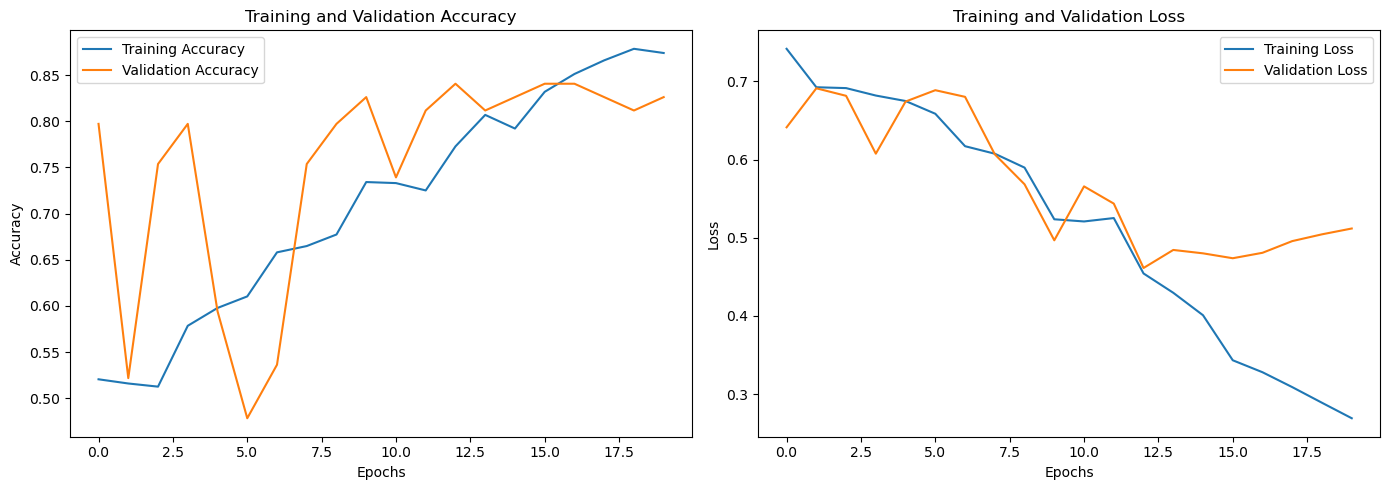

In [5]:
# Plot Accuracy and Loss Curves
def plot_training_curves(history):
    plt.figure(figsize=(14, 5))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
Classification Report:
                   precision    recall  f1-score   support

     No Impaction       0.86      0.86      0.86        56
Angular Impaction       0.43      0.43      0.43        14

         accuracy                           0.77        70
        macro avg       0.64      0.64      0.64        70
     weighted avg       0.77      0.77      0.77        70



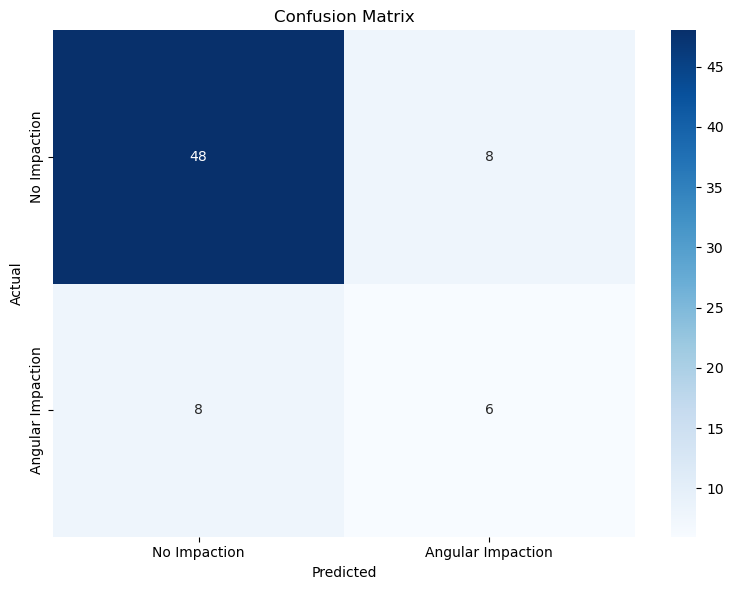

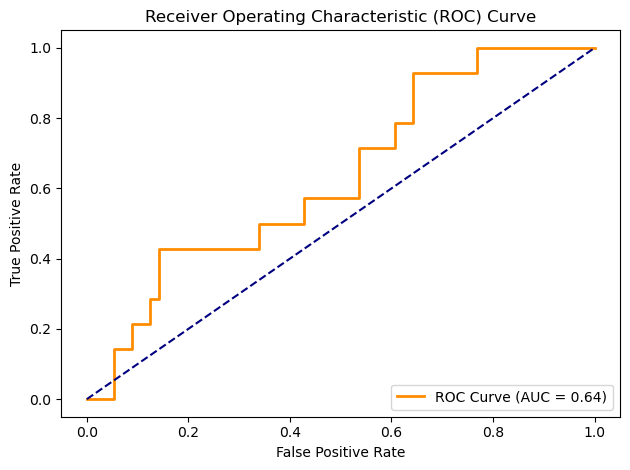

In [6]:
# Evaluate the model
y_pred_prob = model.predict([X_test, X_test])
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Impaction", "Angular Impaction"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Impaction", "Angular Impaction"], yticklabels=["No Impaction", "Angular Impaction"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_cnn_vit.png")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("roc_curve_cnn_vit.png")
plt.show()

Training set shape: (554, 224, 224, 3), (554,)
Validation set shape: (69, 224, 224, 3), (69,)
Test set shape: (70, 224, 224, 3), (70,)
Epoch 1/20


D:\CSE299\Flutter\Anaconda\envs\Research\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_8']. Received: the structure of inputs=('*', '*')
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4956 - loss: 0.7616 - val_accuracy: 0.2029 - val_loss: 0.7315
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5289 - loss: 0.6944 - val_accuracy: 0.2174 - val_loss: 0.7051
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5162 - loss: 0.6902 - val_accuracy: 0.5072 - val_loss: 0.6907
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5972 - loss: 0.6779 - val_accuracy: 0.5942 - val_loss: 0.6739
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5915 - loss: 0.6648 - val_accuracy: 0.5072 - val_loss: 0.6862
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6635 - loss: 0.6224 - val_accuracy: 0.7971 - val_loss: 0.5839
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6995 - loss: 0.5828 - val_accuracy: 0.6957 - val_loss: 0.6101
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7314 - loss: 0.5405 - val_accuracy: 0.7681 - val_loss: 0.5541
Epo

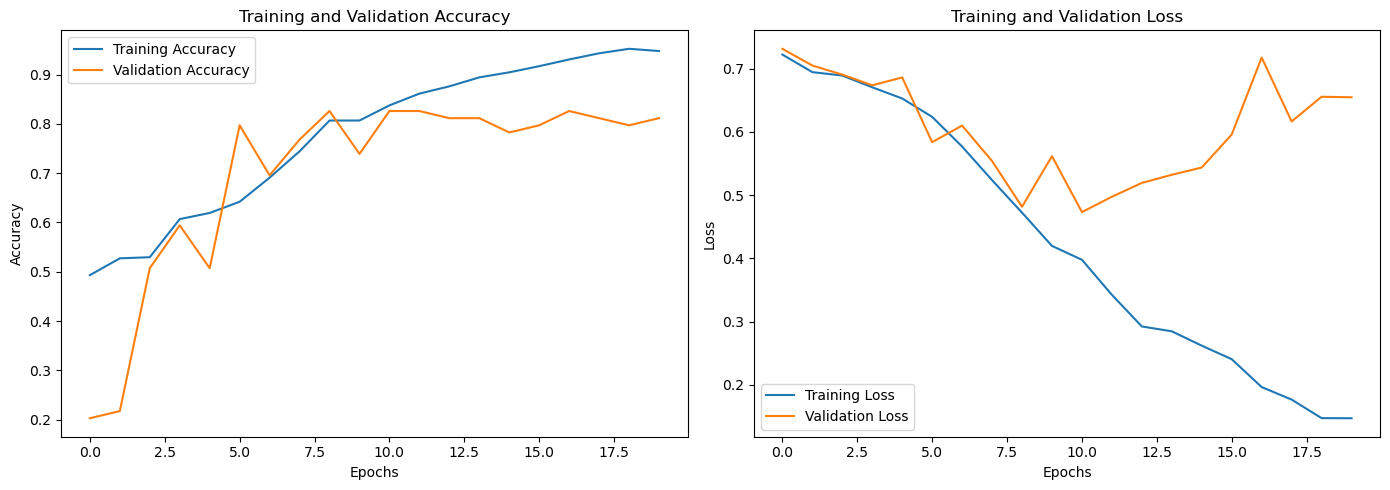

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Classification Report:
                   precision    recall  f1-score   support

     No Impaction       0.82      0.89      0.85        56
Angular Impaction       0.33      0.21      0.26        14

         accuracy                           0.76        70
        macro avg       0.58      0.55      0.56        70
     weighted avg       0.72      0.76      0.74        70



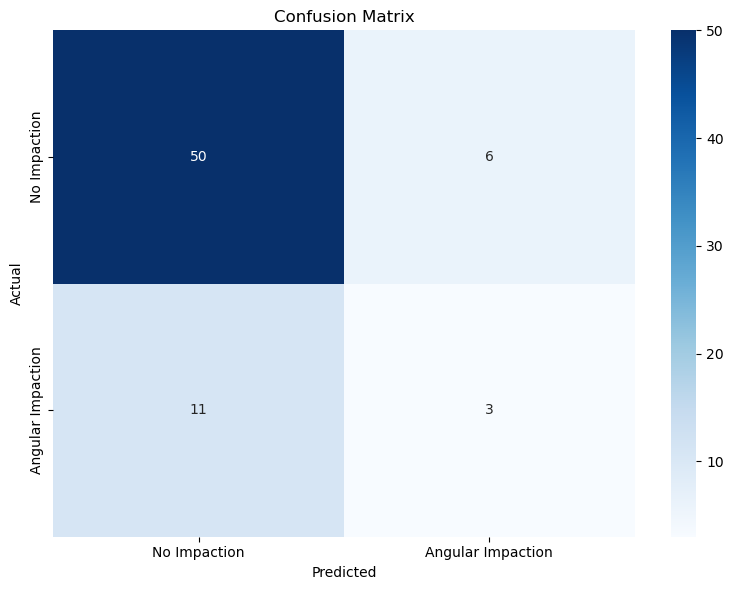

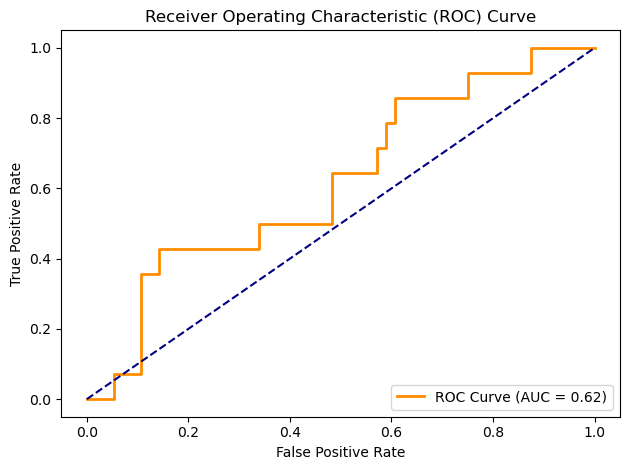

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from PIL import Image

# Paths
classification_dir = r"D:\RESEARCH_WORK\Teeth_Segmentation_Project\Dataset\Merged_dataset\classification_dataset"

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001 

# Function to load dataset
def load_classification_data(directory):
    images = []
    labels = []
    for file in os.listdir(directory):
        if file.endswith((".jpg", ".png", ".jpeg")):
            label = int(file.split('_')[1][0])  # Extract label (0 or 1)
            img_path = os.path.join(directory, file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load data
X, y = load_classification_data(classification_dir)

# Shuffle dataset
X, y = shuffle(X, y, random_state=42)

# Train-validation-test split (8:1:1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# Apply Random Over Sampler
ros = RandomOverSampler(random_state=42)
X_train_flat = X_train.reshape((X_train.shape[0], -1))  # Flatten for oversampling
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train_resampled.reshape((-1, IMG_SIZE[0], IMG_SIZE[1], 3))  # Reshape back 

# CNN + ViT Model
def create_cnn_vit_model():
    # CNN Layers
    cnn_input = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(cnn_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    cnn_output = layers.Flatten()(x)
    
    # ViT Layer
    vit_input = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    vit_patches = layers.Conv2D(8, (16, 16), strides=(16, 16), padding='valid')(vit_input)  # Patch embedding
    vit_patches = layers.Reshape((-1, vit_patches.shape[-1]))(vit_patches)  # Reshape into sequence
    vit_output = layers.MultiHeadAttention(num_heads=4, key_dim=8)(vit_patches, vit_patches)
    vit_output = layers.GlobalAveragePooling1D()(vit_output)
    
    # Concatenate CNN and ViT
    combined = layers.Concatenate()([cnn_output, vit_output])
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    output = layers.Dense(1, activation='sigmoid')(combined)  # Binary classification
    
    model = Model(inputs=[cnn_input, vit_input], outputs=output)
    return model 

# Compile the model
model = create_cnn_vit_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [X_train_resampled, X_train_resampled], y_train_resampled,
    validation_data=([X_val, X_val], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
) 

# Plot Accuracy and Loss Curves
def plot_training_curves(history):
    plt.figure(figsize=(14, 5))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history) 

# Evaluate the model
y_pred_prob = model.predict([X_test, X_test])
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Impaction", "Angular Impaction"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Impaction", "Angular Impaction"], yticklabels=["No Impaction", "Angular Impaction"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_cnn_vit.png")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("roc_curve_cnn_vit.png")
plt.show() 


C:\Users\Salem Shamsul Alam\AppData\Local\Temp\ipykernel_6512\253622442.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"True: {class_names[int(true_label)]}\nPredicted: {class_names[int(y_pred[idx])]}")
C:\Users\Salem Shamsul Alam\AppData\Local\Temp\ipykernel_6512\253622442.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  save_path = os.path.join(save_dir, f"misclassified_{class_names[int(true_label)]}_true_{class_names[int(true_label)]}_predicted_{class_names[int(y_pred[idx])]}_{idx}.png")


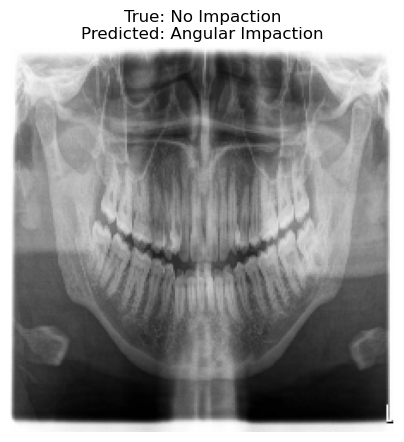

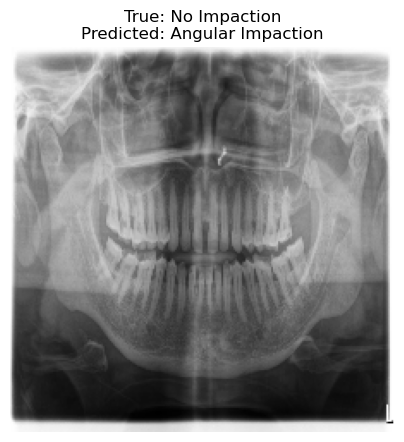

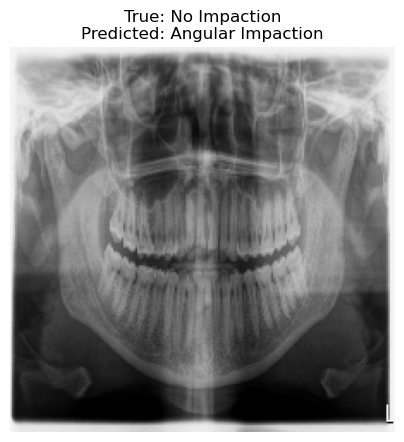

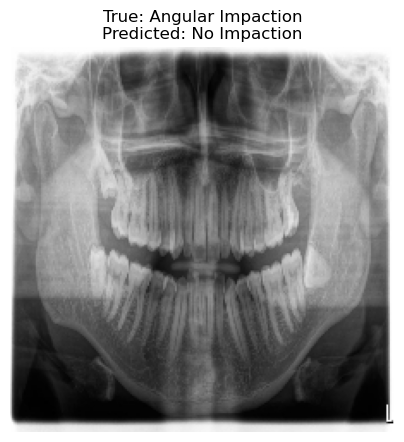

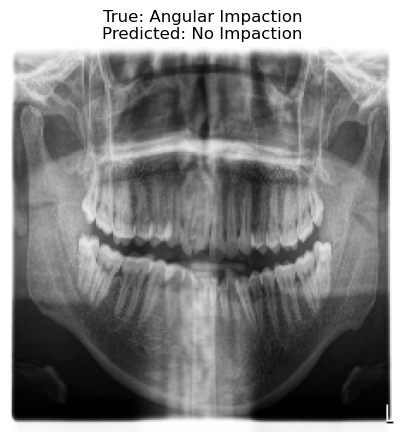

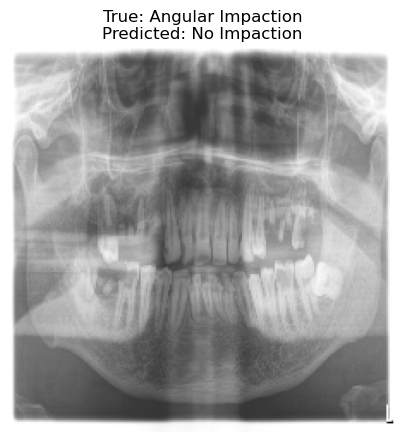

In [2]:
# Function to visualize and save misclassified images
def visualize_and_save_misclassified_images(X_test, y_test, y_pred, filenames, class_names, save_dir='misclassified_images'):
    # Create the directory to save images if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]

    misclassified_images = {0: [], 1: []}  # Store up to 4 misclassified images per class

    # Find up to four misclassified images for each class
    for i in misclassified_indices:
        true_label = y_test[i]
        if len(misclassified_images[true_label]) < 3:  # Only add up to four images per class
            misclassified_images[true_label].append(i)
        if all(len(v) == 3 for v in misclassified_images.values()):  # Found four for each class
            break

    # Display and save misclassified images
    for true_label, indices in misclassified_images.items():
        if len(indices) == 0:
            print(f"No misclassified image found for class {class_names[true_label]}.")
            continue

        for idx in indices:
            # Plot the image with true and predicted label
            plt.figure(figsize=(5, 5))
            plt.imshow(X_test[idx])  # Display image
            plt.axis('off')
            plt.title(f"True: {class_names[int(true_label)]}\nPredicted: {class_names[int(y_pred[idx])]}")

            # Save the misclassified image
            save_path = os.path.join(save_dir, f"misclassified_{class_names[int(true_label)]}_true_{class_names[int(true_label)]}_predicted_{class_names[int(y_pred[idx])]}_{idx}.png")
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.show()

# Call the function to display and save misclassified images
visualize_and_save_misclassified_images(X_test, y_test, y_pred, filenames=[], class_names=["No Impaction", "Angular Impaction"])